In [1]:
#***********************************Fruits classification********************************************
#importing all the required libraries
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
import matplotlib
matplotlib.use("Agg")
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import load_model
from IPython.display import Image
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import imutils
import random
import pickle
import cv2
import os
import operator

#Defining model architecture
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
 
    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

#Preprocessing all the images in the dataset
def preprocess_image(epochs, image_dims, dataset_path, data, labels):
    print("loading images.....")
    imagePaths = sorted(list(paths.list_images(dataset_path)))
    random.seed(42)
    random.shuffle(imagePaths)


    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
        image = img_to_array(image)
        data.append(image)

        l = label = imagePath.split(os.path.sep)[-2].split("_")
        labels.append(l)

    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    encoder=LabelBinarizer()
    labels=encoder.fit_transform(labels)
    for(i,label) in enumerate(encoder.classes_):
        print("{} - {}".format(i+1,label))
    
    return data, labels, encoder

#Splitting the dataset into training and testing set
def split(data, labels):
    return train_test_split(data,labels,test_size=0.25,random_state=42)

#Compiling, training and saving the model to disk
def compile_and_train_model(model_save_location, label_save_location, opt, encoder, trainX, testX, trainY, testY):
    #Compiling, training and saving the model to disk
    print("compiling model............")
    model = build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],depth=IMAGE_DIMS[2], classes=len(encoder.classes_))

    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

    print("training network.........")
    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),validation_data=(testX, testY),steps_per_epoch=len(trainX) // BS,epochs=EPOCHS, verbose=1)

    print("saving model to disk......")
    model.save(model_save_location)

    print("saving label binarizer to disk......")
    f = open(label_save_location, "wb")
    f.write(pickle.dumps(encoder))
    f.close()

    return H

#Plotting a graph between Epochs and Loss/Accuracy
def plot_graph(H):
    plt.style.use("ggplot")
    plt.figure()
    N = EPOCHS
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper left")
    plt.savefig("plot")
    plt.show()

#Function to classify new fruit        
def predict_label(model_save_location, label_save_location, new_image):
    print("loading model from disk........")
    model = load_model(model_save_location)
    mlb = pickle.loads(open(label_save_location, "rb").read())
    image = cv2.imread(new_image)
    output = imutils.resize(image, width=400)

    image = cv2.resize(image, (65, 65))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    print("classifying image....")
    proba = model.predict(image)[0]
    idxs = np.argsort(proba)[::-1][:2]

    dict={}
    for (label, p) in zip(mlb.classes_, proba):
        dict[label]=p
    print(max(dict.items(), key=operator.itemgetter(1))[0])

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ModuleNotFoundError: No module named 'imutils'

In [19]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (65, 65, 3)
DATASET_PATH = "fruits_dataset/dataset"
data = []
labels = []
aug=ImageDataGenerator(rotation_range=25,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode="nearest")

data, labels, encoder = preprocess_image(EPOCHS, IMAGE_DIMS, DATASET_PATH, data, labels)
trainX,testX,trainY,testY=split(data, labels)
H=compile_and_train_model("model_rmsprop","label_bin","rmsprop", encoder, trainX, testX, trainY, testY)

loading images.....
1 - Apple Braeburn
2 - Apple Golden 1
3 - Apple Golden 2
4 - Apple Golden 3
5 - Apple Granny Smith
6 - Apple Red 1
7 - Apple Red 2
8 - Apple Red 3
9 - Apple Red Delicious
10 - Apple Red Yellow 1
11 - Apple Red Yellow 2
12 - Apricot
13 - Avocado
14 - Avocado ripe
15 - Banana
16 - Banana Lady Finger
17 - Banana Red
18 - Cactus fruit
19 - Cantaloupe 1
20 - Cantaloupe 2
21 - Carambula
22 - Cherry 1
23 - Cherry 2
24 - Cherry Rainier
25 - Cherry Wax Black
26 - Cherry Wax Red
27 - Cherry Wax Yellow
28 - Chestnut
29 - Clementine
30 - Cocos
31 - Dates
32 - Granadilla
33 - Grape Blue
34 - Grape Pink
35 - Grape White
36 - Grape White 2
37 - Grape White 3
38 - Grape White 4
39 - Grapefruit Pink
40 - Grapefruit White
41 - Guava
42 - Hazelnut
43 - Huckleberry
44 - Kaki
45 - Kiwi
46 - Kumquats
47 - Lemon
48 - Lemon Meyer
49 - Limes
50 - Lychee
51 - Mandarine
52 - Mango
53 - Mangostan
54 - Maracuja
55 - Melon Piel de Sapo
56 - Mulberry
57 - Nectarine
58 - Orange
59 - Papaya
60 - Pa

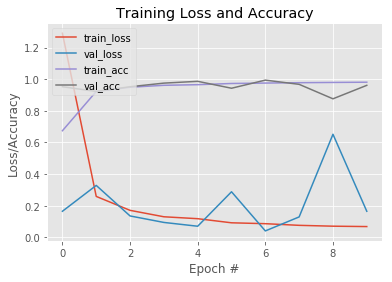

In [20]:
plot_graph(H)

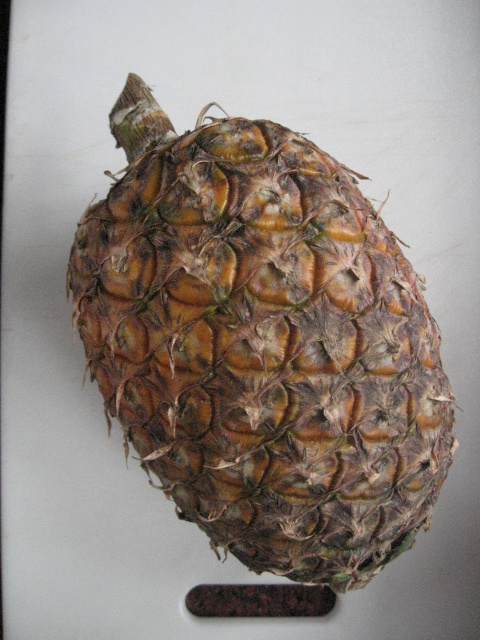

In [35]:
Image(filename='samples/sample_pineapple.jpg',width=140,height=140)

In [36]:
predict_label("model_rmsprop","label_bin","samples/sample_pineapple.jpg")

loading model from disk........
classifying image....
Pineapple


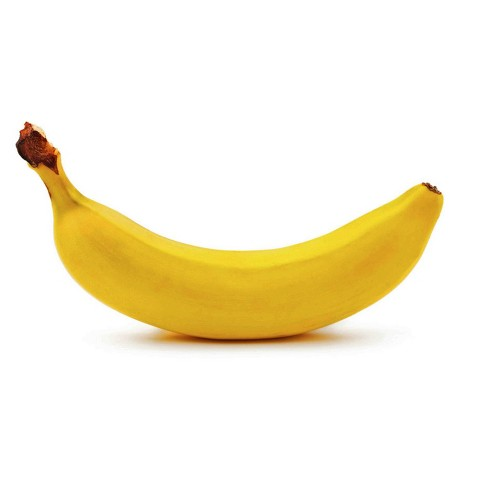

In [37]:
Image(filename='samples/sample_banana.jpg',width=140,height=140)

In [39]:
predict_label("model_rmsprop","label_bin","samples/sample_banana.jpg")

loading model from disk........
classifying image....
Banana Lady Finger


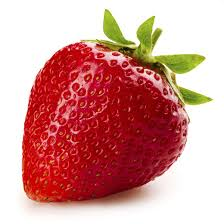

In [40]:
Image(filename='samples/sample_strawberry.jpg',width=140,height=140)

In [41]:
predict_label("model_rmsprop","label_bin","samples/sample_strawberry.jpg")

loading model from disk........
classifying image....
Strawberry


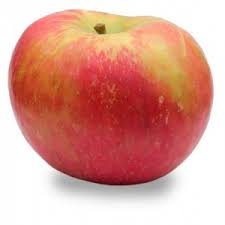

In [42]:
Image(filename='samples/sample_apple.jpg',width=140,height=140)

In [43]:
predict_label("model_rmsprop","label_bin","samples/sample_apple.jpg")

loading model from disk........
classifying image....
Tomato Cherry Red


In [45]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (65, 65, 3)
DATASET_PATH = "fruits_dataset/dataset"
data = []
labels = []
aug=ImageDataGenerator(rotation_range=25,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode="nearest")

data, labels, encoder = preprocess_image(EPOCHS, IMAGE_DIMS, DATASET_PATH, data, labels)
trainX,testX,trainY,testY=split(data, labels)
opt = Adam(lr=INIT_LR, decay=INIT_LR / 10)
H=compile_and_train_model("model_adam","label_adam", opt, encoder, trainX, testX, trainY, testY)

loading images.....
1 - Apple Braeburn
2 - Apple Golden 1
3 - Apple Golden 2
4 - Apple Golden 3
5 - Apple Granny Smith
6 - Apple Red 1
7 - Apple Red 2
8 - Apple Red 3
9 - Apple Red Delicious
10 - Apple Red Yellow 1
11 - Apple Red Yellow 2
12 - Apricot
13 - Avocado
14 - Avocado ripe
15 - Banana
16 - Banana Lady Finger
17 - Banana Red
18 - Cactus fruit
19 - Cantaloupe 1
20 - Cantaloupe 2
21 - Carambula
22 - Cherry 1
23 - Cherry 2
24 - Cherry Rainier
25 - Cherry Wax Black
26 - Cherry Wax Red
27 - Cherry Wax Yellow
28 - Chestnut
29 - Clementine
30 - Cocos
31 - Dates
32 - Granadilla
33 - Grape Blue
34 - Grape Pink
35 - Grape White
36 - Grape White 2
37 - Grape White 3
38 - Grape White 4
39 - Grapefruit Pink
40 - Grapefruit White
41 - Guava
42 - Hazelnut
43 - Huckleberry
44 - Kaki
45 - Kiwi
46 - Kumquats
47 - Lemon
48 - Lemon Meyer
49 - Limes
50 - Lychee
51 - Mandarine
52 - Mango
53 - Mangostan
54 - Maracuja
55 - Melon Piel de Sapo
56 - Mulberry
57 - Nectarine
58 - Orange
59 - Papaya
60 - Pa

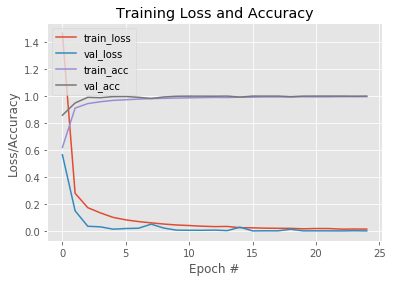

In [46]:
plot_graph(H)

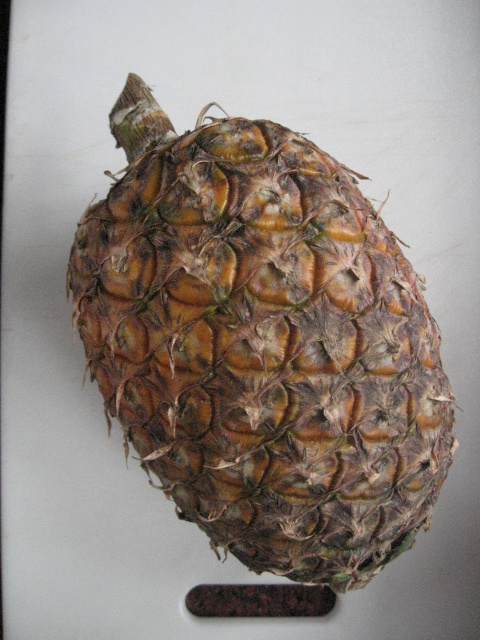

In [47]:
Image(filename='samples/sample_pineapple.jpg',width=140,height=140)

In [49]:
predict_label("model_adam","label_adam","samples/sample_pineapple.jpg")

loading model from disk........
classifying image....
Pineapple


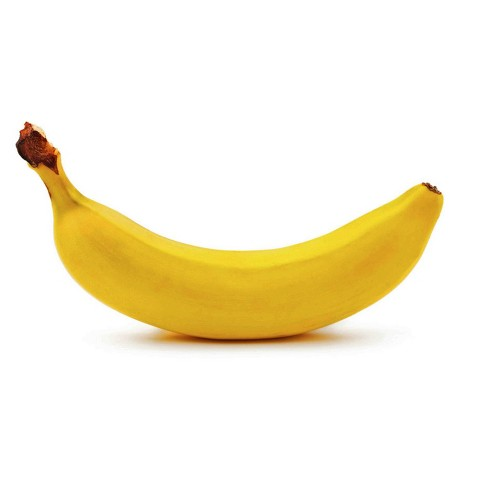

In [50]:
Image(filename='samples/sample_banana.jpg',width=140,height=140)

In [51]:
predict_label("model_adam","label_adam","samples/sample_banana.jpg")

loading model from disk........
classifying image....
Banana Lady Finger


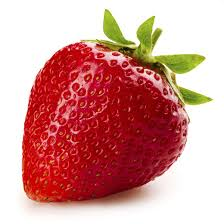

In [52]:
Image(filename='samples/sample_strawberry.jpg',width=140,height=140)

In [53]:
predict_label("model_adam","label_adam","samples/sample_strawberry.jpg")

loading model from disk........
classifying image....
Strawberry


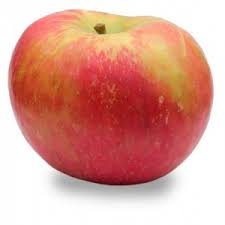

In [54]:
Image(filename='samples/sample_apple.jpg',width=140,height=140)

In [55]:
predict_label("model_adam","label_adam","samples/sample_apple.jpg")

loading model from disk........
classifying image....
Apple Red Yellow 1


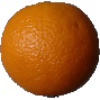

In [56]:
Image(filename='samples/sample_orange.jpg',width=140,height=140)

In [57]:
predict_label("model_adam","label_adam","samples/sample_orange.jpg")

loading model from disk........
classifying image....
Orange


In [ ]:
Observations:

Accuracy was used as evaluation metrics since each fruit class contains almost equal number of images.
The accuracy of final model is better than initial model.
Graphs for both the models were plotted.
Graphs cleary show that validation accuracies of both the models are increasing with increase in epoches.
The initial model failed to classify some fruits.
The final model was able to classify new sample images accurately.